In [22]:
cols = {
    "loan_id": 1,
    "orig_interest_rate": 7,
    "orig_upb": 9,
    "orig_loan_term": 12,
    "orig_date": 13,
    # "orig_ltv": 19,
    # "orig_dti": 22,
    # "orig_credit_score": 23,
    "amortization_type": 34,
    "interest_only": 36,
    "zero_balance_code": 43,
    "zero_balance_date": 44,
    "upb_at_removal": 45,
    "foreclosure_costs": 53,
    "preservation_and_repair_costs": 54,
    "asset_recovery_costs": 55,
    "misc_holding_costs": 56,
    "holding_taxes_costs": 57,
    "net_sales_proceeds": 58,
    "credit_enhancement_proceeds": 59,
    "repurchase_make_whole_proceeds": 60,
    "other_foreclosure_proceeds": 61
}

col_indexes = cols.values()

In [23]:
def get_months(date_num: float) -> int:
    date_str = str(int(date_num))
    month = date_str[:-4]
    year = date_str[-4:]

    return int(month) + 12 * int(year)

In [24]:
import pandas as pd
import numpy as np

data_2020Q1 = pd.read_csv(
    "data/2024Q1.csv",
    delimiter="|",
    header=None,
    nrows=10_000_000,
    usecols=col_indexes
)[col_indexes]
data_2020Q1.columns = cols.keys()

data_2020Q1 = data_2020Q1[
    (data_2020Q1["amortization_type"] == "FRM") &
    (data_2020Q1["interest_only"] == "N") &
    data_2020Q1["zero_balance_code"].notna()
].drop(
    columns=["amortization_type", "interest_only"]
).set_index("loan_id")

data_2020Q1["active_months"] = \
    (data_2020Q1["zero_balance_date"].apply(get_months) - data_2020Q1["orig_date"].apply(get_months))
data_2020Q1.drop(
    columns=["orig_date", "zero_balance_date"],
    inplace=True
)

data_2020Q1

,orig_interest_rate,orig_upb,orig_loan_term,zero_balance_code,upb_at_removal,foreclosure_costs,preservation_and_repair_costs,asset_recovery_costs,misc_holding_costs,holding_taxes_costs,net_sales_proceeds,credit_enhancement_proceeds,repurchase_make_whole_proceeds,other_foreclosure_proceeds,active_months
loan_id,,,,,,,,,,,,,,,
137581457,7.125,722000.0,360,1.0,716926.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
137581467,6.875,151000.0,360,1.0,148985.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
137581477,7.399,305000.0,360,1.0,303352.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
137581481,6.250,75000.0,180,1.0,72943.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
137581490,7.250,227000.0,216,1.0,223342.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138004053,6.750,214000.0,360,1.0,110402.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
138004055,6.990,266000.0,360,1.0,265000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
138004080,7.250,455000.0,360,1.0,453000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7


In [25]:
def compute_total_interest(row):
    P = row["orig_upb"]
    r = row["orig_interest_rate"] / 100
    n = row["orig_loan_term"]
    m = row["active_months"]
    
    i = r / 12
    if n <= 0 or m <= 0:
        return 0.0
    M = P * (i * (1 + i)**n) / ((1 + i)**n - 1)
    balance = P
    total_interest = 0.0
    for _ in range(int(m)):
        interest = balance * i
        principal = M - interest
        balance -= principal
        total_interest += interest
    return total_interest

data_2020Q1["interest_paid"] = data_2020Q1.apply(
    compute_total_interest, 
    axis=1
)
data_2020Q1.drop(
    columns=["orig_loan_term", "active_months"],
    inplace=True
)

data_2020Q1

,orig_interest_rate,orig_upb,zero_balance_code,upb_at_removal,foreclosure_costs,preservation_and_repair_costs,asset_recovery_costs,misc_holding_costs,holding_taxes_costs,net_sales_proceeds,credit_enhancement_proceeds,repurchase_make_whole_proceeds,other_foreclosure_proceeds,interest_paid
loan_id,,,,,,,,,,,,,,
137581457,7.125,722000.0,1.0,716926.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46963.677983
137581467,6.875,151000.0,1.0,148985.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7759.420175
137581477,7.399,305000.0,1.0,303352.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16873.199368
137581481,6.250,75000.0,1.0,72943.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3846.254582
137581490,7.250,227000.0,1.0,223342.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12229.953036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138004053,6.750,214000.0,1.0,110402.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11990.155230
138004055,6.990,266000.0,1.0,265000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9277.462406
138004080,7.250,455000.0,1.0,453000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19197.218634


In [26]:
default_costs_cols = list(data_2020Q1.columns[data_2020Q1.columns.str.endswith("_costs")])
default_proceeds_cols = list(data_2020Q1.columns[data_2020Q1.columns.str.endswith("_proceeds")])
default_codes = [2, 3, 9, 15, 16]

data_2020Q1.loc[:, "lgd"] = np.nan

defaulted_loan_ids = data_2020Q1["zero_balance_code"].isin(default_codes)

ids = defaulted_loan_ids & data_2020Q1.loc[:, default_costs_cols + default_proceeds_cols].notna().any(axis=1)
data_2020Q1.loc[ids, "lgd"] = (data_2020Q1.loc[ids, "upb_at_removal"] + data_2020Q1.loc[ids, default_costs_cols].sum(axis=1) \
    - data_2020Q1.loc[ids, default_proceeds_cols].sum(axis=1)) / data_2020Q1.loc[ids, "upb_at_removal"]
data_2020Q1.drop(columns=default_costs_cols + default_proceeds_cols, inplace=True)

data_2020Q1

,orig_interest_rate,orig_upb,zero_balance_code,upb_at_removal,interest_paid,lgd
loan_id,,,,,,
137581457,7.125,722000.0,1.0,716926.69,46963.677983,NaN
137581467,6.875,151000.0,1.0,148985.57,7759.420175,NaN
137581477,7.399,305000.0,1.0,303352.98,16873.199368,NaN
137581481,6.250,75000.0,1.0,72943.24,3846.254582,NaN
137581490,7.250,227000.0,1.0,223342.96,12229.953036,NaN
...,...,...,...,...,...,...
138004053,6.750,214000.0,1.0,110402.43,11990.155230,NaN
138004055,6.990,266000.0,1.0,265000.00,9277.462406,NaN
138004080,7.250,455000.0,1.0,453000.00,19197.218634,NaN


In [27]:
notna_lgd_ids = data_2020Q1["lgd"].notna()

for code in default_codes:
    code_ids = data_2020Q1["zero_balance_code"] == code
    ids = code_ids & notna_lgd_ids

    if ids.sum() == 0:
        mean_lgd = 0.6
    else:
        mean_lgd = data_2020Q1.loc[ids, "lgd"].mean()

    data_2020Q1.loc[code_ids & (~notna_lgd_ids), "lgd"] = 1

data_2020Q1

,orig_interest_rate,orig_upb,zero_balance_code,upb_at_removal,interest_paid,lgd
loan_id,,,,,,
137581457,7.125,722000.0,1.0,716926.69,46963.677983,NaN
137581467,6.875,151000.0,1.0,148985.57,7759.420175,NaN
137581477,7.399,305000.0,1.0,303352.98,16873.199368,NaN
137581481,6.250,75000.0,1.0,72943.24,3846.254582,NaN
137581490,7.250,227000.0,1.0,223342.96,12229.953036,NaN
...,...,...,...,...,...,...
138004053,6.750,214000.0,1.0,110402.43,11990.155230,NaN
138004055,6.990,266000.0,1.0,265000.00,9277.462406,NaN
138004080,7.250,455000.0,1.0,453000.00,19197.218634,NaN


In [28]:
data_2020Q1.loc[defaulted_loan_ids, "net"] = data_2020Q1["interest_paid"] - data_2020Q1["upb_at_removal"] * data_2020Q1["lgd"]
data_2020Q1.loc[~defaulted_loan_ids, "net"] = data_2020Q1["interest_paid"]

[]

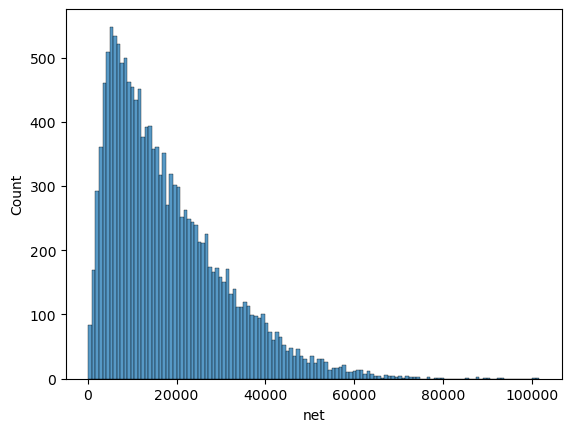

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(
    data=data_2020Q1[~defaulted_loan_ids],
    x="net",
    bins=128,
    legend="net"
)

plt.plot()

In [30]:
default_rate = defaulted_loan_ids.mean()

default_rate

np.float64(0.00026535756932466497)

In [31]:
def simulate_portfolio(
    returns_paid: np.ndarray,
    returns_defaulted: np.ndarray,
    default_rate: float,
    N=10000,
    n=100
) -> np.ndarray:
    n_paid = int(n * (1 - default_rate))
    n_defaulted = int(n * default_rate)

    index_paid = np.random.randint(0, len(returns_paid), size=(N, n_paid))
    index_defaulted = np.random.randint(0, len(returns_defaulted), size=(N, n_defaulted))

    samples_paid = np.take(returns_paid, index_paid)
    samples_defaulted = np.take(returns_defaulted, index_defaulted)

    mc_returns = samples_paid.sum(axis=1) + samples_defaulted.sum(axis=1)

    return mc_returns

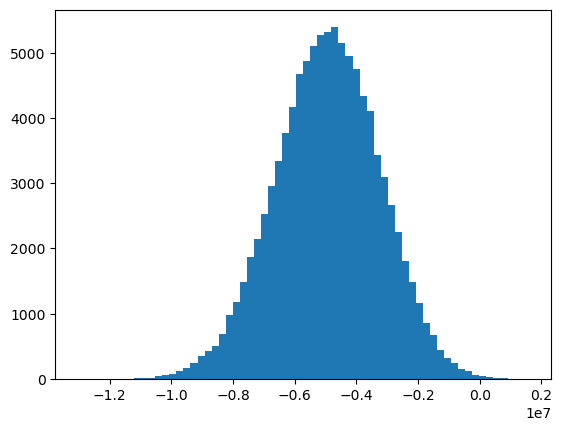

In [32]:
hist_returns = simulate_portfolio(
    data_2020Q1["net"][~defaulted_loan_ids].values,
    data_2020Q1["net"][defaulted_loan_ids].values,
    default_rate=0.1,
    N=100_000,
    n=1_000
)

plt.hist(
    hist_returns,
    bins=64
)
plt.show()